In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Library

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import pearsonr
from scipy.signal import find_peaks
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
%matplotlib inline

font_size = 16
# Specify the path to save containing data CSV files
root_path = '/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait'
# path = '/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait/Moin'
# path2 = '/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait/Avanti'
# path3 = '/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait/Kartikee'
# path4 = '/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait/Rufaida'
fs = 104
cutoff_frequency = 2  # Hz
filter_types = ['butterworth']
# Specify the path to save the result CSV file
result_path = '/content/drive/MyDrive/VLSIDC/Result'

# Functions

In [ ]:
def apply_lowpass_filters(data, sampling_frequency, cutoff_frequency, filter_types, filter_order=4):
    """
    Apply multiple lowpass filters (including moving average) to the input data and calculate correlation coefficients.

    Parameters:
    - data (array-like): The input data to filter.
    - sampling_frequency (float): The sampling frequency of the input data (in Hz).
    - cutoff_frequency (float): The cutoff frequency of the lowpass filters (in Hz).
    - filter_types (list of str): A list of filter types to use ('butterworth', 'chebyshev1', 'chebyshev2', 'moving_average').
    - filter_order (int): The order of the filters (only applicable to certain filter types).

    Returns:
    - results (dict): A dictionary containing filtered data and correlation coefficients for each filter type.
    """
    nyquist_frequency = 0.5 * sampling_frequency
    results = {}

    for filter_type in filter_types:
        if filter_type == 'butterworth':
            b, a = signal.butter(filter_order, cutoff_frequency / nyquist_frequency, btype='low')
            filtered_data = signal.filtfilt(b, a, data)
        elif filter_type == 'chebyshev1':
            b, a = signal.cheby1(filter_order, 1, cutoff_frequency / nyquist_frequency, btype='low')
            filtered_data = signal.filtfilt(b, a, data)
        elif filter_type == 'chebyshev2':
            b, a = signal.cheby2(filter_order, 30, cutoff_frequency / nyquist_frequency, btype='low')
            filtered_data = signal.filtfilt(b, a, data)
        elif filter_type == 'moving_average':
            filter_window = int(sampling_frequency / cutoff_frequency)  # Window size for moving average
            filtered_data = np.convolve(data, np.ones(filter_window) / filter_window, mode='same')
        else:
            raise ValueError("Invalid filter_type. Supported types: 'butterworth', 'chebyshev1', 'chebyshev2', 'moving_average'")

        correlation_coefficient, _ = pearsonr(data, filtered_data)

        results[filter_type] = {
            'filtered_data': filtered_data,
            'correlation_coefficient': correlation_coefficient
        }

    return results

# Data Read

In [ ]:
csv_files = []
# Iterate through each folder in the root directory
for folder_name in os.listdir(root_path):
    folder_path = os.path.join(root_path, folder_name)

    # Check if the item in the root directory is a folder
    if os.path.isdir(folder_path):
        # Iterate through each file in the folder
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)

            # Check if the file has a .csv extension
            if file_name.endswith('.csv') and os.path.isfile(file_path):
                # Append the full file path to the csv_files list
                csv_files.append(file_path)

# Print the list of full file paths for CSV files
for csv_file in csv_files:
  print(csv_file)

/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait/Kartikee/data01.csv
/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait/Kartikee/data03.csv
/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait/Kartikee/data04.csv
/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait/Kartikee/data05.csv
/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait/Kartikee/data02.csv
/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait/Kartikee/data06.csv
/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait/Kartikee/data07.csv
/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait/Kartikee/data08.csv
/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait/Kartikee/data09.csv
/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait/Kartikee/data10.csv
/content/drive/MyDrive/VLSIDC/VLSIDesignContestDataset/healthy gait/Kartikee/data11.csv
/content/drive/MyDrive/VLSIDC/VL

In [ ]:
# csv_files = [file for file in os.listdir(path) if file.endswith('.csv')]
dataframes = []
# Loop through each CSV file and read it into a separate dataframe
for csv_file in csv_files:
  print(csv_file)
  # # Construct the full file path
  # file_path = os.path.join(path, csv_file)

  # Read the CSV file into a dataframe
  data = pd.read_csv(csv_file)
  # # Store the dataframe in the dictionary with the file name as the key
  # dataframes[csv_file] = data

  HeelADCRaw = data['Heel ADC0']
  MidFootADCRaw = data['MidFoot ADC1']
  ToeADCRaw = data['Toe ADC2']

  GyroXRaw = data[' GyroX (deg/s)']
  GyroXRaw = GyroXRaw - np.min(GyroXRaw)
  GyroYRaw = data[' GyroY (deg/s)']
  GyroYRaw = GyroYRaw - np.min(GyroYRaw)
  GyroZRaw = data[' GyroZ (deg/s)']
  GyroZRaw = GyroZRaw - np.min(GyroZRaw)

  AccXRaw = data[' AccX (g)']
  AccYRaw = data[' AccY (g)']
  AccZRaw = data[' AccZ (g)']

  start, end = 0, len(GyroZRaw)
  GyroXRawSeg = GyroXRaw[start: end]
  GyroYRawSeg = GyroYRaw[start: end]
  GyroZRawSeg = GyroZRaw[start: end]

  results1 = apply_lowpass_filters(AccXRaw, fs, cutoff_frequency, filter_types, 2)
  for filter_type, result in results1.items():
    AccXFiltSeg = result['filtered_data']
  results1 = apply_lowpass_filters(AccYRaw, fs, cutoff_frequency, filter_types, 2)
  for filter_type, result in results1.items():
    AccYFiltSeg = result['filtered_data']
  results1 = apply_lowpass_filters(AccZRaw, fs, cutoff_frequency, filter_types, 2)
  for filter_type, result in results1.items():
    AccZFiltSeg = result['filtered_data']

  results1 = apply_lowpass_filters(GyroXRawSeg, fs, cutoff_frequency, filter_types, 2)
  for filter_type, result in results1.items():
    GyroXFiltSeg = result['filtered_data']
  results1 = apply_lowpass_filters(GyroYRawSeg, fs, cutoff_frequency, filter_types, 2)
  for filter_type, result in results1.items():
    GyroYFiltSeg = result['filtered_data']
  results1 = apply_lowpass_filters(GyroZRawSeg, fs, cutoff_frequency, filter_types, 2)
  for filter_type, result in results1.items():
    GyroZFiltSeg = result['filtered_data']

  # plt.figure(figsize=(20, 10))
  # plt.subplot(211)
  # plt.title('Filtered Signal', fontsize = font_size)
  # plt.plot(GyroZRawSeg, label='Raw Data', alpha=0.6, linewidth=2)
  # plt.ylabel('Amplitude', fontsize = font_size)
  # plt.legend(fontsize = font_size)
  # plt.grid(True)
  # plt.tight_layout()
  # plt.subplot(212)
  # plt.plot(GyroZFiltSeg, label='Filtered Data', alpha=0.6, linewidth=2)
  # plt.xlabel('Samples', fontsize = font_size)
  # plt.ylabel('Amplitude', fontsize = font_size)
  # plt.legend(fontsize = font_size)
  # plt.grid(True)
  # plt.tight_layout()
  # plt.show()

  ## Find max of the given window
  max_window = max(GyroZFiltSeg)
  # print(max_window)

  ## Find the lower threshold based on max found
  thr = 0.32
  low_thr = int(max_window - (0.32 * max_window))
  # print(max_window, low_thr)

  ## Begin MSw Finding based on Max peak detetion and locallized peak detection
  ## Find the local peaks based on lower threshold
  GyroZPksPos, _ = find_peaks(GyroZFiltSeg, height=low_thr, distance=fs//1)
  GyroZPksVal = GyroZFiltSeg[GyroZPksPos]
  # print(GyroZPksVal, GyroZPksPos)

  # plt.figure(figsize=(20, 5))
  # plt.title('Peak Finding [Major Swing]', fontsize = font_size)
  # plt.plot(GyroZFiltSeg, label='Filtered Data', alpha=0.6, linewidth=2)
  # plt.plot(GyroZPksPos, GyroZFiltSeg[GyroZPksPos], "x", label='MSw')
  # plt.xlabel('Samples', fontsize = font_size)
  # plt.ylabel('Amplitude', fontsize = font_size)
  # plt.legend(fontsize = font_size)
  # plt.grid(True)
  # plt.tight_layout()
  # plt.show()

  ## Begin finding the TO (towards Left of MSw) and IC (towards Right of MSw)
  GyroZPksPosLeftMin, GyroZPksPosRightMin = [], []
  for i in range(len(GyroZPksPos)):
    if (i == 0):
      low, high = (GyroZPksPos[i]), (GyroZPksPos[i]+50)
      b = GyroZPksPos[i] + np.argmin(GyroZFiltSeg[low : high])
      #print(b, GyroZPksPos[i])
      GyroZPksPosRightMin.append(b)
    else:
      #print(i)
      low, high = (GyroZPksPos[i]-50), (GyroZPksPos[i])
      a = GyroZPksPos[i] - 50 + np.argmin(GyroZFiltSeg[low : high])
      #print(a, GyroZPksPos[i])
      GyroZPksPosLeftMin.append(a)

      if ((GyroZPksPos[i]+50) > len(GyroZFiltSeg)):
        continue
      else:
        low, high = (GyroZPksPos[i]), (GyroZPksPos[i]+50)
        b = GyroZPksPos[i] + np.argmin(GyroZFiltSeg[low : high])
        #print(b, GyroZPksPos[i])
        GyroZPksPosRightMin.append(b)

  # plt.figure(figsize=(20, 5))
  # plt.title('Peak Finding [Major-Swing (MSw), Toe-Off (TO), Initial Contact (IC)]', fontsize = font_size)
  # plt.plot(GyroZFiltSeg, label='Filtered Data', alpha=0.6, linewidth=2)
  # plt.plot(GyroZPksPos, GyroZFiltSeg[GyroZPksPos], "x", label='MSw')
  # plt.plot(GyroZPksPosLeftMin, GyroZFiltSeg[GyroZPksPosLeftMin], "x", label='TO')
  # plt.plot(GyroZPksPosRightMin, GyroZFiltSeg[GyroZPksPosRightMin], "x", label='IC')
  # plt.xlabel('Samples', fontsize = font_size)
  # plt.ylabel('Amplitude', fontsize = font_size)
  # plt.legend(fontsize = font_size)
  # plt.grid(True)
  # plt.tight_layout()
  # plt.show()

  ## Begin Finding MSt (Between IC and TO)
  if (GyroZPksPosLeftMin > GyroZPksPosRightMin):
    loop_len = len(GyroZPksPosLeftMin)
  else:
    loop_len = len(GyroZPksPosRightMin)

  GyroZPksPosMSt = []
  for i in range(loop_len):
    low, high = (GyroZPksPosRightMin[i]), (GyroZPksPosLeftMin[i])
    a = GyroZPksPosRightMin[i] + np.argmax(GyroZFiltSeg[low : high])
    #print(a, GyroZPksPos[i])
    GyroZPksPosMSt.append(a)

  # plt.figure(figsize=(20, 5))
  # plt.title('Peak Finding [Major-Swing (MSw), Toe-Off (TO), Initial Contact (IC), Major-Stance (MSt)]', fontsize = font_size)
  # plt.plot(GyroZFiltSeg, label='Filtered Data', alpha=0.6, linewidth=2)
  # plt.plot(GyroZPksPos, GyroZFiltSeg[GyroZPksPos], "x", label='MSw')
  # plt.plot(GyroZPksPosLeftMin, GyroZFiltSeg[GyroZPksPosLeftMin], "x", label='TO')
  # plt.plot(GyroZPksPosRightMin, GyroZFiltSeg[GyroZPksPosRightMin], "x", label='IC')
  # plt.plot(GyroZPksPosMSt, GyroZFiltSeg[GyroZPksPosMSt], "x", label='MSt')
  # plt.xlabel('Samples', fontsize = font_size)
  # plt.ylabel('Amplitude', fontsize = font_size)
  # plt.legend(fontsize = font_size)
  # plt.grid(True)
  # plt.tight_layout()
  # plt.show()

  # MSw = Orange; IC = Red; MSt = Purple; TO = Green
  # label ->
  # 0 = IC to MSt
  # 1 = MSt to TO
  # 2 = TO to MSw
  # 3 = MSw to IC
  # 4 = N/A

  label = []
  for n in range(0, GyroZPksPos[0]):
    label.append(4)

  for idx in range(len(GyroZPksPos)-1):
    for m in range(GyroZPksPos[idx], GyroZPksPosRightMin[idx]):
      label.append(3)
    for j in range(GyroZPksPosRightMin[idx], GyroZPksPosMSt[idx]):
      label.append(0)
    for k in range(GyroZPksPosMSt[idx], GyroZPksPosLeftMin[idx]):
      label.append(1)
    for i in range(GyroZPksPosLeftMin[idx], GyroZPksPos[idx+1]):
      label.append(2)
    # print(GyroZPksPos[idx], GyroZPksPosRightMin[idx], GyroZPksPosMSt[idx], GyroZPksPosLeftMin[idx])

  for o in range(GyroZPksPos[len(GyroZPksPos)-1], len(GyroZFiltSeg)):
    label.append(4)

  # labels = tf.constant(label)
  # num_classes = tf.reduce_max(labels) + 1
  # one_hot_encoded = tf.one_hot(labels, depth=num_classes)
  # for i in one_hot_encoded:
  #   print(i)

  # for i in range(len(label)):
  #   label[i] = label[i]*100 + int(np.mean(GyroZFiltSeg))

  fig, ax1 = plt.subplots(figsize=(20, 5))
  plt.title('Peak Finding [Major-Swing (MSw), Toe-Off (TO), Initial Contact (IC), Major-Stance (MSt)]', fontsize=font_size)
  # Plotting on the first y-axis
  ax1.plot(GyroZFiltSeg, label='Filtered Data', alpha=0.6, linewidth=2)
  ax1.plot(GyroZPksPos, GyroZFiltSeg[GyroZPksPos], "x", label='MSw')
  ax1.plot(GyroZPksPosLeftMin, GyroZFiltSeg[GyroZPksPosLeftMin], "x", label='TO')
  ax1.plot(GyroZPksPosRightMin, GyroZFiltSeg[GyroZPksPosRightMin], "x", label='IC')
  ax1.plot(GyroZPksPosMSt, GyroZFiltSeg[GyroZPksPosMSt], "x", label='MSt')
  ax1.set_xlabel('Samples', fontsize=font_size)
  ax1.set_ylabel('Amplitude', fontsize=font_size)
  ax1.legend(loc='upper left', fontsize=font_size)
  # Creating a second y-axis
  ax2 = ax1.twinx()
  ax2.plot(label, "--", label='Label', color='orange')
  ax2.set_ylabel('Label', fontsize=font_size)
  # Manually setting tick labels
  tick_labels = ['Heel Strike', 'Mid-Stance', 'Toe-Off', 'Mid Swing', 'N/A']
  ax2.set_yticks([0, 1, 2, 3, 4])
  ax2.set_yticklabels(tick_labels, fontsize=font_size)
  ax2.legend(loc='upper right', fontsize=font_size)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  # Create a dataframe with the specified columns
  df = pd.DataFrame({
        'AccX (g)': AccXFiltSeg,
        'AccY (g)': AccYFiltSeg,
        'AccZ (g)': AccZFiltSeg,
        'GyroX (deg/s)': GyroXFiltSeg,
        'GyroY (deg/s)': GyroYFiltSeg,
        'GyroZ (deg/s)': GyroZFiltSeg,
        'Heel ADC0': HeelADCRaw,
        'MidFoot ADC1': MidFootADCRaw,
        'Toe ADC2': ToeADCRaw,
        'LABEL': label
    })

  df = df[df['LABEL'] != 4]
  # Perform one-hot encoding on the 'LABEL' column
  df = pd.get_dummies(df, columns=['LABEL'], prefix='label')
  # df['LABEL'].value_counts().plot(kind='bar') #Plot freuqncy of class

  # print(df.head())

  dataframes.append(df)


# Save Labelled data into CSV file

In [ ]:
# # This code will store the result in same columns.
# # Ensure the result directory exists
# os.makedirs(result_path, exist_ok=True)

# # Concatenate all dataframes in the list
# result_df = pd.concat(dataframes, ignore_index=True)

# # Save the concatenated dataframe to a CSV file
# result_file_path = os.path.join(result_path, 'result.csv')
# result_df.to_csv(result_file_path, index=False)

# print(f"Result CSV file saved at: {result_file_path}")

In [ ]:
# # This code will store the result in different columns.
# # Set the path to save the result CSV file
# result_file = 'result.csv'

# # Create the result directory if it doesn't exist
# if not os.path.exists(result_path):
#     os.makedirs(result_path)

# # Assuming 'dataframes' is the list of dataframes from the previous code
# # Create a dictionary to store dataframes as columns
# df_dict = {'df{}'.format(i): df for i, df in enumerate(dataframes)}

# # Create a single dataframe with columns as dataframes
# result_df = pd.concat(df_dict, axis=1)

# # Save the result dataframe to a CSV file
# result_df.to_csv(os.path.join(result_path, result_file), index=False)

In [ ]:
# This code will store the result in different CSV files.

# Create the result directory if it doesn't exist
if not os.path.exists(result_path):
    os.makedirs(result_path)
else:
    # Delete all files in the result_path directory
    files_to_delete = os.listdir(result_path)
    for file_to_delete in files_to_delete:
        file_path = os.path.join(result_path, file_to_delete)
        os.remove(file_path)

# Save each dataframe to a separate CSV file
for i, df in enumerate(dataframes):
    csv_file = f'df_{i}.csv'
    csv_path = os.path.join(result_path, csv_file)
    df.to_csv(csv_path, index=False)


# Machine Learning Section

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.12.0


## Loading the dataset

In [ ]:
new_csv_files = [file for file in os.listdir(result_path) if file.endswith('.csv')]
print(new_csv_files)

for i, csv_file in enumerate(new_csv_files):
    file_path = os.path.join(result_path, csv_file)
    df_data = pd.read_csv(file_path)
    if (i == 0):
      df_data_append = df_data
    else:
      df_data_append = pd.concat([df_data_append, df_data], ignore_index=True)

recordings = df_data_append.to_numpy()
print("recordings shape:", recordings.shape)

['df_0.csv', 'df_54.csv', 'df_44.csv', 'df_53.csv', 'df_52.csv', 'df_1.csv', 'df_55.csv', 'df_2.csv', 'df_3.csv', 'df_5.csv', 'df_6.csv', 'df_4.csv', 'df_7.csv', 'df_8.csv', 'df_10.csv', 'df_9.csv', 'df_14.csv', 'df_11.csv', 'df_12.csv', 'df_13.csv', 'df_17.csv', 'df_16.csv', 'df_15.csv', 'df_18.csv', 'df_19.csv', 'df_20.csv', 'df_21.csv', 'df_24.csv', 'df_25.csv', 'df_23.csv', 'df_22.csv', 'df_26.csv', 'df_27.csv', 'df_28.csv', 'df_29.csv', 'df_30.csv', 'df_33.csv', 'df_34.csv', 'df_31.csv', 'df_35.csv', 'df_36.csv', 'df_32.csv', 'df_38.csv', 'df_37.csv', 'df_39.csv', 'df_40.csv', 'df_41.csv', 'df_43.csv', 'df_42.csv', 'df_45.csv', 'df_48.csv', 'df_46.csv', 'df_47.csv', 'df_50.csv', 'df_49.csv', 'df_51.csv', 'df_59.csv', 'df_57.csv', 'df_58.csv', 'df_56.csv']
recordings shape: (284513, 13)


In [ ]:
print(recordings[:, -4:])

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [ ]:
# Split the 'all_frames' array into 'x_frames' and 'y_frames'
x_recording = recordings[:, :-4]  # Take the first 9 columns for each frame
y_recording = recordings[:, -4:]   # Take the last column for each frame

print("x_recording shape:", x_recording.shape)
print("y_recording shape:", y_recording.shape)

x_recording shape: (284513, 9)
y_recording shape: (284513, 4)


## Frame data

In [ ]:
def frame(x, frame_len, hop_len):
    ''' Slice a 3D data array into (overlapping) frames. '''

    assert(x.shape == (len(x), x.shape[1]))
    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)

    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides_x = ((hop_len * x.strides[0],) + x.strides)

    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides_x)

# all_frames = frame(recordings, 26, 26) # no overlap
x_frames = frame(x_recording, 25, 7) # 50% overlap
x_frames = np.array(x_frames)
print(x_frames.shape)
y_frames = frame(y_recording, 25, 7) # 50% overlap
y_frames = np.array(y_frames)
print(y_frames.shape)

(40642, 25, 9)
(40642, 25, 4)


## Preprocessing the dataset

In [ ]:
# # Normalize x_frames between [-1;1]
# min_val = np.min(x_frames)
# max_val = np.max(x_frames)
# x_frames_normed = -1 + 2 * (x_frames - min_val) / (max_val - min_val)
# print("Normalized x_frame shape:", x_frames_normed.shape)

# Normalize x_frames between [-1, 1] - for every col
min_val = np.min(x_frames, axis=(0, 1))  # Calculate minimum along axes 0 and 1
max_val = np.max(x_frames, axis=(0, 1))  # Calculate maximum along axes 0 and 1
x_frames_normed = -1 + 2 * (x_frames - min_val) / (max_val - min_val)
print("Original x_frames shape:", x_frames.shape)
print("Normalized x_frames shape:", x_frames_normed.shape)
# x_frames_normed[0]

Original x_frames shape: (40642, 25, 9)
Normalized x_frames shape: (40642, 25, 9)


In [ ]:
appen_label = []
for j in range(0, len(y_frames)):
  appen_label.append(np.argmax(np.sum(y_frames[j], axis=0)))
  # print(y_frames[j], '\n', np.argmax(np.sum(y_frames[j], axis=0)), '\n')
  # # print(y_frames[j], '\n', np.argmax(np.bincount(np.argmax(y_frames[j], axis=1))), '\n')
y_frames = np.array(appen_label)
# print("x_frames shape:", x_frames.shape)
# print("y_frames shape:", y_frames.shape)

In [ ]:
# Display the one-hot encoded array
print("Original array:")
print(y_frames)
# Perform one-hot encoding
y_frames = tf.keras.utils.to_categorical(y_frames, num_classes=4)
print("\nOne-hot encoded array:")
print(y_frames)

print("x_frames shape:", x_frames.shape)
print("y_frames shape:", y_frames.shape)

Original array:
[3 3 3 ... 2 2 2]

One-hot encoded array:
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
x_frames shape: (40642, 25, 9)
y_frames shape: (40642, 4)


## Preparing the dataset (train, test, split)

In [ ]:
# Assuming x_data and y_data are your features and labels
x_train_temp, x_test, y_train_temp, y_test = train_test_split(x_frames_normed, y_frames, test_size=0.2, random_state=42)

# Split the temporary set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.25, random_state=42)

# Display the shapes of the resulting sets
print("Training set shapes:", x_train.shape, y_train.shape)
print("Validation set shapes:", x_val.shape, y_val.shape)
print("Test set shapes:", x_test.shape, y_test.shape)

Training set shapes: (24384, 25, 9) (24384, 4)
Validation set shapes: (8129, 25, 9) (8129, 4)
Test set shapes: (8129, 25, 9) (8129, 4)


## Creating the model

In [ ]:
## Conv1D based model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=8, kernel_size=5, activation='relu', input_shape=(25, 9)),
  tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.1), #0.5 too large
  tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.MaxPooling1D(pool_size=2), # maxpool

  tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
  tf.keras.layers.MaxPooling1D(pool_size=2), # maxpool

  tf.keras.layers.Flatten(),
  # tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=30)

Epoch 1/30
762/762 [==============================] - 5s 5ms/step - loss: 0.3152 - accuracy: 0.8723
Epoch 2/30
762/762 [==============================] - 5s 6ms/step - loss: 0.1787 - accuracy: 0.9259
Epoch 3/30
762/762 [==============================] - 6s 8ms/step - loss: 0.1534 - accuracy: 0.9348
Epoch 4/30
762/762 [==============================] - 4s 5ms/step - loss: 0.1371 - accuracy: 0.9414
Epoch 5/30
762/762 [==============================] - 3s 5ms/step - loss: 0.1249 - accuracy: 0.9473
Epoch 6/30
762/762 [==============================] - 4s 5ms/step - loss: 0.1179 - accuracy: 0.9494
Epoch 7/30
762/762 [==============================] - 6s 8ms/step - loss: 0.1097 - accuracy: 0.9535
Epoch 8/30
762/762 [==============================] - 5s 7ms/step - loss: 0.1078 - accuracy: 0.9548
Epoch 9/30
762/762 [==============================] - 4s 5ms/step - loss: 0.1020 - accuracy: 0.9572
Epoch 10/30
762/762 [==============================] - 5s 6ms/step - loss: 0.0984 - accuracy: 0.9590

## Evaluate Model for Test and Validation data

In [ ]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print("Test loss:", test_loss)
print("Test acc:", test_acc)
print()
model.summary()

255/255 - 2s - loss: 0.0632 - accuracy: 0.9738 - 2s/epoch - 7ms/step
Test loss: 0.06319670379161835
Test acc: 0.9737975001335144

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 21, 8)             368       
                                                                 
 conv1d_28 (Conv1D)          (None, 19, 16)            400       
                                                                 
 dropout_7 (Dropout)         (None, 19, 16)            0         
                                                                 
 conv1d_29 (Conv1D)          (None, 17, 32)            1568      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 8, 32)            0         
 g1D)                                                            
                                                        

In [ ]:
val_loss, val_acc = model.evaluate(x_val,  y_val, verbose=2)

print("Test loss:", val_loss)
print("Test acc:", val_acc)
print()
model.summary()

255/255 - 1s - loss: 0.0682 - accuracy: 0.9720 - 861ms/epoch - 3ms/step
Test loss: 0.06820133328437805
Test acc: 0.9719522595405579

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 21, 8)             368       
                                                                 
 conv1d_28 (Conv1D)          (None, 19, 16)            400       
                                                                 
 dropout_7 (Dropout)         (None, 19, 16)            0         
                                                                 
 conv1d_29 (Conv1D)          (None, 17, 32)            1568      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 8, 32)            0         
 g1D)                                                            
                                                     

## Predicted Data

In [ ]:
Y_pred = model.predict(x_test)

255/255 [==============================] - 1s 3ms/step


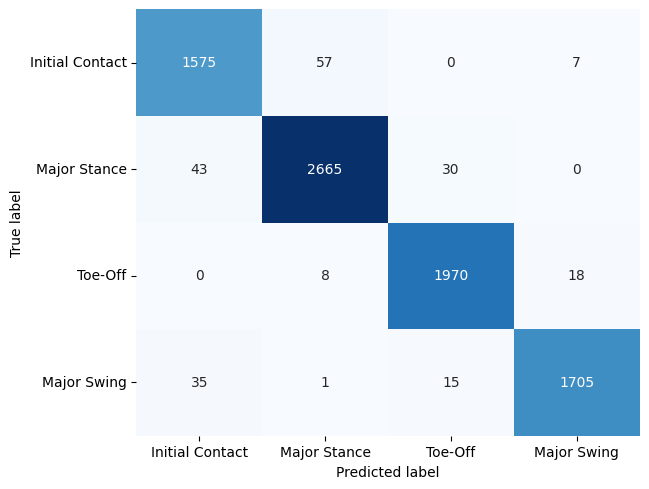

In [ ]:
for i in range(len(Y_pred)):
  for j in range(len(Y_pred[i])):
    if (Y_pred[i][j] < 0.5):
      Y_pred[i][j] = 0
    else:
      Y_pred[i][j] = 1

# Retrieve the original labels for each row
original_labels = np.argmax(Y_pred, axis=1)
true_labels = np.argmax(y_test, axis=1)
# print("Original Labels:", original_labels)

# for i in range(len(Y_pred)):
#   print(original_labels[i], Y_pred[i], y_test[i])

# k=3
# plt.plot(original_labels[k: k+100], '.-', label='Predited Label')
# plt.plot(original_labels[k: k+100], '.-', label='True Label')
# plt.legend()

labels = ['Initial Contact', 'Major Stance', 'Toe-Off', 'Major Swing']
confusion_matrix = tf.math.confusion_matrix(true_labels, original_labels)
plt.figure()
sns.heatmap(confusion_matrix,
            annot=True,
            xticklabels=labels,
            yticklabels=labels,
            cmap=plt.cm.Blues,
            fmt='d', cbar=False)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Export the model

In [ ]:
# Save the model into an HDF5 file ‘model.h5’
model.save('/content/drive/MyDrive/VLSIDC/Model/model.h5')